In [1]:
# For reproducibility with CuBLAS
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

In [2]:
import re
import random
import textwrap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from tqdm import tqdm
from typing import List, Optional, Tuple, Dict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, multilabel_confusion_matrix

import pickle
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
os.getcwd()

'/content'

In [5]:
import os

# Disable Colab’s automatic /kaggle/input caching
os.environ["KAGGLEHUB_DISABLE_COLAB_CACHE"] = "1"

import kagglehub

path = kagglehub.dataset_download("snikhilrao/chexlocalize-dataset")
print("Downloaded dataset path:", path)


100%|██████████| 2.83G/2.83G [02:09<00:00, 23.5MB/s]

Extracting files...


Downloaded dataset path: /root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1


In [6]:
!ls /root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1

chexlocalize_dataset


In [ ]:
import os

root = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1"
for path, dirs, files in os.walk(root):
    if 'gradcam_maps_val' in path:
        print(path)
        break


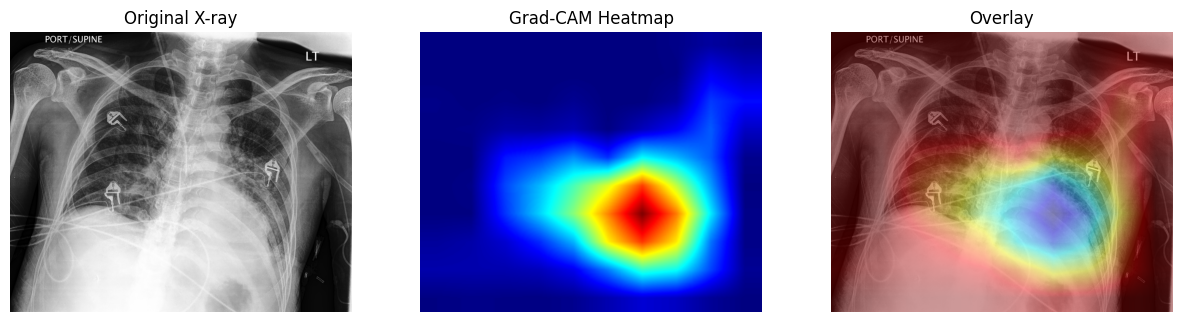

In [7]:
import os
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt



# 1. paths
heatmap_folder =  "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXlocalize/gradcam_maps_val"
image_folder = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/patient64669/study1"
heatmap_file = "patient64669_study1_view1_frontal_Airspace Opacity_map.pkl"
image_file   = "view1_frontal.jpg"

pkl_path = os.path.join(heatmap_folder, heatmap_file)
img_path = os.path.join(image_folder, image_file)

# 2. load image
orig = cv2.imread(img_path)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

# 3. load heatmap
with open(pkl_path, "rb") as f:
    data = pickle.load(f)

arr = next(iter(data.values())) if isinstance(data, dict) else data
arr = np.squeeze(np.array(arr))  # (1,1,320,320) -> (320,320)

# 4. normalize + color
arr_norm = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
arr_uint8 = (arr_norm * 255).astype(np.uint8)
heatmap = cv2.applyColorMap(arr_uint8, cv2.COLORMAP_JET)

# 5. resize
heatmap_resized = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))

# 6. overlay
overlay = cv2.addWeighted(orig, 0.6, heatmap_resized, 0.4, 0)

# 7. show everything
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(orig)
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


In [12]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16

# ----------------------
# Load checkpoint
# ----------------------
ckpt_path = "/content/vit_seed_999_best_model (1).pth"
checkpoint = torch.load(ckpt_path, map_location="cuda")

# ----------------------
# Recreate EXACT architecture
# ----------------------
model = vit_b_16(weights=None)

# Your model is 768 → 8
model.heads.head = nn.Linear(model.heads.head.in_features, 8)

model = model.to("cuda")

# ----------------------
# Load weights
# ----------------------
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Loaded ViT-B/16 with 8 classes successfully!")


Loaded ViT-B/16 with 8 classes successfully!


In [13]:
# final_vit_explainability_fixed.py
import os
import pickle
import json
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torchvision.models import vit_b_16
import pandas as pd

# -----------------------------
# ========== SETTINGS =========
# -----------------------------
CHECKPOINT_PATH = "/content/vit_seed_999_best_model (1).pth"
IMAGE_ROOT = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/"
HEATMAP_ROOT  = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXlocalize/gradcam_maps_val"

NUM_CLASSES     = 8
STEPS           = 30
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_PREFIX      = "vit_explainability"

print("DEVICE:", DEVICE)

# -----------------------------
# ========== MODEL ============
# -----------------------------
# Create ViT-B/16 architecture and set classifier to match NUM_CLASSES
model = vit_b_16(weights=None)           # architecture: ViT-B/16
model.heads.head = nn.Linear(768, NUM_CLASSES)

# Load checkpoint (safe handling)
ck = torch.load(CHECKPOINT_PATH, map_location="cpu")

# If checkpoint stores a nested dict (e.g., "model_state_dict"), use it; otherwise use ck directly
if "model_state_dict" in ck:
    state_dict = ck["model_state_dict"]
else:
    state_dict = ck

# Try to load: if strict fails (unlikely since NUM_CLASSES=8), fallback to safe removal of head keys then strict=False
try:
    model.load_state_dict(state_dict)
    print("Loaded checkpoint with strict=True")
except Exception as e:
    print("Strict load failed:", e)
    # remove common classifier keys if mismatched and load with strict=False
    sd = dict(state_dict)  # copy
    removed = []
    for k in list(sd.keys()):
        # possible classifier key names in various ViT implementations
        if k.endswith("head.weight") or k.endswith("head.bias") or "heads.head" in k or "fc_norm" in k:
            removed.append(k)
            del sd[k]
    print("Removed keys due to mismatch:", removed)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print("Loaded with strict=False. Missing keys:", missing)
    print("Unexpected keys:", unexpected)

model = model.to(DEVICE)
model.eval()

print("Model loaded.")

# -----------------------------
# ========== TRANSFORMS =======
# -----------------------------
norm = transforms.Normalize(mean=[0.485,0.456,0.406],
                            std=[0.229,0.224,0.225])

transform_raw = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

transform_input = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    norm
])

# -----------------------------
# ========== METRICS ==========
# -----------------------------
def average_drop(o, m):
    return max(0, (o - m) / (o + 1e-6))

def increase_in_conf(o, m):
    return max(0, (m - o) / (o + 1e-6))

def heatmap_entropy(h):
    # h is numpy array normalized to [0,1]
    s = h.sum()
    if s <= 0:
        return 0.0
    h_norm = h / s
    return -np.sum(h_norm * np.log(h_norm + 1e-12))

def heatmap_sparsity(h):
    return 1.0 - (np.count_nonzero(h) / h.size)

def deletion_metric(model, img_raw, hm, steps=30):
    """
    Gradually remove (set to 0) most important pixels according to heatmap and record model max score.
    img_raw: tensor [3,H,W] in range [0,1] (un-normalized)
    hm: numpy array HxW with values in [0,1]
    """
    H, W = hm.shape
    flat = hm.flatten()
    order = np.argsort(-flat)  # descending importance indices (numpy)

    raw = img_raw.clone().to(DEVICE)
    mask = torch.ones(H * W, device=DEVICE)

    scores = []
    for s in range(steps):
        k = int((s + 1) / steps * len(order))
        if k > 0:
            # set top-k to 0
            mask[order[:k]] = 0

        m2d = mask.view(H, W)
        m3 = m2d.unsqueeze(0).expand_as(raw)  # [3,H,W]

        masked = raw * m3
        inp = norm(masked).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            out = model(inp)
            # out shape: [1, NUM_CLASSES]
            scores.append(out.max().item())

    return scores

def insertion_metric(model, img_raw, hm, steps=30):
    """
    Gradually insert (reveal) most important pixels according to heatmap starting from blank image.
    Uses blurred=0 (black) baseline similar to your original code.
    """
    H, W = hm.shape
    flat = hm.flatten()
    order = np.argsort(-flat)

    raw = img_raw.clone().to(DEVICE)
    mask = torch.zeros(H * W, device=DEVICE)
    blurred = torch.zeros_like(raw)  # baseline black image

    scores = []
    for s in range(steps):
        k = int((s + 1) / steps * len(order))
        if k > 0:
            mask[order[:k]] = 1

        m2d = mask.view(H, W)
        m3 = m2d.unsqueeze(0).expand_as(raw)

        new = blurred * (1 - m3) + raw * m3
        inp = norm(new).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            out = model(inp)
            scores.append(out.max().item())

    return scores

# -----------------------------
# ========== MAIN LOOP ========
# -----------------------------
results = []
missing_hm = 0
missing_img = 0

patients = sorted([p for p in os.listdir(IMAGE_ROOT)
                   if "patient" in p.lower()])

for patient in tqdm(patients):
    img_path = os.path.join(IMAGE_ROOT, patient, "study1", "view1_frontal.jpg")
    if not os.path.exists(img_path):
        missing_img += 1
        continue

    # ---- AUTOFIND HEATMAP ----
    prefix = f"{patient}_study1_view1_frontal"
    candidates = [f for f in os.listdir(HEATMAP_ROOT) if f.startswith(prefix)]
    if len(candidates) == 0:
        missing_hm += 1
        continue
    heatmap_path = os.path.join(HEATMAP_ROOT, candidates[0])

    # ---- Load image ----
    try:
        pil = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Could not open image {img_path}: {e}")
        missing_img += 1
        continue

    img_raw = transform_raw(pil).float()        # [3,224,224], range [0,1]
    img_input = norm(img_raw).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        orig_out = model(img_input)
        orig_score = orig_out.max().item()

    # ---- Load heatmap ----
    try:
        d = pickle.load(open(heatmap_path, "rb"))
    except Exception as e:
        print(f"Could not load heatmap {heatmap_path}: {e}")
        missing_hm += 1
        continue

    if "map" in d:
        hm = d["map"]
    elif "heatmap" in d:
        hm = d["heatmap"]
    else:
        # try direct object
        hm = d

    if torch.is_tensor(hm):
        hm = hm.cpu().numpy()
    while hasattr(hm, "ndim") and hm.ndim > 2:
        hm = hm.squeeze()

    # Normalize heatmap to [0,1]
    try:
        if hm.max() != hm.min():
            hm = (hm - hm.min()) / (hm.max() - hm.min())
        else:
            hm = np.zeros_like(hm, dtype=np.float32)
    except Exception:
        hm = np.zeros((224, 224), dtype=np.float32)

    # Resize heatmap to 224x224
    try:
        hm = np.array(Image.fromarray((hm * 255).astype("uint8")).resize((224, 224))) / 255.0
    except Exception:
        # if hm is already float in [0,1] shape (224,224) this should be fine
        if hm.shape != (224, 224):
            hm = np.zeros((224, 224), dtype=np.float32)

    hm_t = torch.tensor(hm, dtype=torch.float32)

    # ---- Masked image ----
    mask3 = hm_t.unsqueeze(0).expand_as(img_raw)  # [3,224,224]
    masked_raw = img_raw * mask3
    masked_input = norm(masked_raw).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        masked_out = model(masked_input)
        masked_score = masked_out.max().item()

    # ---- Metrics ----
    ad = average_drop(orig_score, masked_score)
    ic = increase_in_conf(orig_score, masked_score)
    ent = heatmap_entropy(hm)
    spr = heatmap_sparsity(hm)

    del_curve = deletion_metric(model, img_raw, hm, steps=STEPS)
    ins_curve = insertion_metric(model, img_raw, hm, steps=STEPS)

    results.append({
        "patient": patient,
        "avg_drop": ad,
        "inc_conf": ic,
        "entropy": ent,
        "sparsity": spr,
        "deletion": del_curve,
        "insertion": ins_curve
    })

print("Missing images:", missing_img)
print("Missing heatmaps:", missing_hm)
print("Processed:", len(results))

if len(results) == 0:
    raise SystemExit("❌ No results found.")

# -----------------------------
# ========== SAVE RESULTS =====
# -----------------------------
df = pd.DataFrame(results)
df.to_pickle(f"{OUT_PREFIX}_results.pkl")
df.to_csv(f"{OUT_PREFIX}_results.csv", index=False)

print("Saved results:", f"{OUT_PREFIX}_results.csv")


DEVICE: cuda
Loaded checkpoint with strict=True
Model loaded.


100%|██████████| 200/200 [06:35<00:00,  1.98s/it]

Missing images: 0
Missing heatmaps: 0
Processed: 200
Saved results: vit_explainability_results.csv


In [14]:
summary = {
    "avg_drop_mean": float(df["avg_drop"].mean()),
    "avg_drop_std":  float(df["avg_drop"].std()),

    "inc_conf_mean": float(df["inc_conf"].mean()),
    "inc_conf_std":  float(df["inc_conf"].std()),

    "entropy_mean": float(df["entropy"].mean()),
    "entropy_std":  float(df["entropy"].std()),

    "sparsity_mean": float(df["sparsity"].mean()),
    "sparsity_std":  float(df["sparsity"].std()),

    "n_images": len(df)
}

# aggregate deletion/insertion curves
deletion_array  = np.stack(df["deletion"].values)
insertion_array = np.stack(df["insertion"].values)

summary["deletion_curve_mean"] = deletion_array.mean(axis=0).tolist()
summary["deletion_curve_std"]  = deletion_array.std(axis=0).tolist()
summary["insertion_curve_mean"] = insertion_array.mean(axis=0).tolist()
summary["insertion_curve_std"]  = insertion_array.std(axis=0).tolist()

with open(f"{OUT_PREFIX}_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved summary to", f"{OUT_PREFIX}_summary.json")
print("Summary:", {k: summary[k] for k in summary if "curve" not in k})



Saved summary to vit_explainability_summary.json
Summary: {'avg_drop_mean': 0.23285681720249637, 'avg_drop_std': 0.08879863139719851, 'inc_conf_mean': 0.00032781760010747245, 'inc_conf_std': 0.0037452202820172035, 'entropy_mean': 9.636682463443389, 'entropy_std': 0.4842337319831815, 'sparsity_mean': 0.4110986328125, 'sparsity_std': 0.218719746384018, 'n_images': 200}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted class: 0


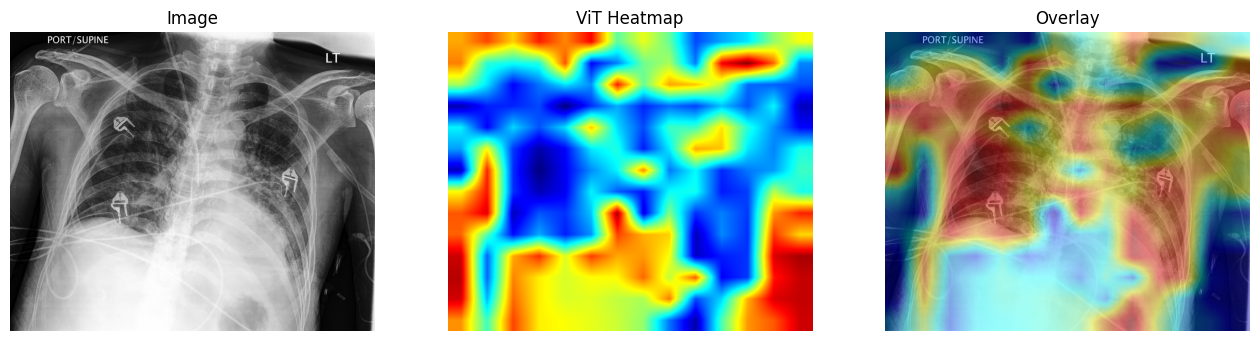

In [15]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import vit_b_16
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------
# Load Image
# ---------------------------
img_path = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/patient64669/study1/view1_frontal.jpg"

img = Image.open(img_path).convert("RGB")

orig_np = np.array(img)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tensor_img = transform(img).unsqueeze(0).cuda()

# ---------------------------
# Load your ViT model
# ---------------------------
model = vit_b_16(weights=None)
model.heads.head = nn.Linear(768, 8)   # 8 classes

ck = torch.load("/content/vit_seed_999_best_model (1).pth", map_location="cpu")
state_dict = ck["model_state_dict"]
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()

# ---------------------------
# Grad-CAM for ViT
# ---------------------------
class ViTGradCAM:
    def __init__(self, model, target_block):
        self.model = model
        self.target_block = target_block

        self.activations = None
        self.gradients = None

        target_block.register_forward_hook(self.forward_hook)
        target_block.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        # output: (batch, seq_len, hidden_dim)
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self):
        # CLS token is index 0
        grad = self.gradients.mean(dim=1, keepdim=True)  # (B,1,D)

        cam = (grad * self.activations).sum(dim=-1)  # (B, seq_len)
        cam = cam[:, 1:]  # remove CLS token

        cam = cam.reshape(1, 14, 14)  # ViT-B/16 → 14×14 patches

        cam = torch.relu(cam)
        cam = cam / cam.max()

        return cam[0].detach().cpu().numpy()

# Use last transformer encoder block
target_block = model.encoder.layers[-1]

cam = ViTGradCAM(model, target_block)

# ---------------------------
# Forward Pass
# ---------------------------
out = model(tensor_img)
class_idx = out.argmax().item()
print("Predicted class:", class_idx)

model.zero_grad()
out[0, class_idx].backward()

heatmap = cam.generate()

# ---------------------------
# Upsample heatmap to image size
# ---------------------------
heatmap = cv2.resize(heatmap, (orig_np.shape[1], orig_np.shape[0]))
heatmap_norm = (heatmap * 255).astype(np.uint8)
heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)

overlay = cv2.addWeighted(orig_np, 0.6, heatmap_color, 0.4, 0)

# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.imshow(orig_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB))
plt.title("ViT Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


SEED 123

In [16]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16

# ----------------------
# Load checkpoint
# ----------------------
ckpt_path = "/content/best_seed_123_model (1).pth"
checkpoint = torch.load(ckpt_path, map_location="cuda")

# ----------------------
# Recreate EXACT architecture
# ----------------------
model = vit_b_16(weights=None)

# Your model is 768 → 8
model.heads.head = nn.Linear(model.heads.head.in_features, 8)

model = model.to("cuda")

# ----------------------
# Load weights
# ----------------------
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Loaded ViT-B/16 with 8 classes successfully!")


Loaded ViT-B/16 with 8 classes successfully!


In [17]:
# final_vit_explainability_fixed.py
import os
import pickle
import json
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torchvision.models import vit_b_16
import pandas as pd

# -----------------------------
# ========== SETTINGS =========
# -----------------------------
CHECKPOINT_PATH = "/content/best_seed_123_model (1).pth"
IMAGE_ROOT = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/"
HEATMAP_ROOT  = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXlocalize/gradcam_maps_val"

NUM_CLASSES     = 8
STEPS           = 30
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_PREFIX      = "vit_explainability"

print("DEVICE:", DEVICE)

# -----------------------------
# ========== MODEL ============
# -----------------------------
# Create ViT-B/16 architecture and set classifier to match NUM_CLASSES
model = vit_b_16(weights=None)           # architecture: ViT-B/16
model.heads.head = nn.Linear(768, NUM_CLASSES)

# Load checkpoint (safe handling)
ck = torch.load(CHECKPOINT_PATH, map_location="cpu")

# If checkpoint stores a nested dict (e.g., "model_state_dict"), use it; otherwise use ck directly
if "model_state_dict" in ck:
    state_dict = ck["model_state_dict"]
else:
    state_dict = ck

# Try to load: if strict fails (unlikely since NUM_CLASSES=8), fallback to safe removal of head keys then strict=False
try:
    model.load_state_dict(state_dict)
    print("Loaded checkpoint with strict=True")
except Exception as e:
    print("Strict load failed:", e)
    # remove common classifier keys if mismatched and load with strict=False
    sd = dict(state_dict)  # copy
    removed = []
    for k in list(sd.keys()):
        # possible classifier key names in various ViT implementations
        if k.endswith("head.weight") or k.endswith("head.bias") or "heads.head" in k or "fc_norm" in k:
            removed.append(k)
            del sd[k]
    print("Removed keys due to mismatch:", removed)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print("Loaded with strict=False. Missing keys:", missing)
    print("Unexpected keys:", unexpected)

model = model.to(DEVICE)
model.eval()

print("Model loaded.")

# -----------------------------
# ========== TRANSFORMS =======
# -----------------------------
norm = transforms.Normalize(mean=[0.485,0.456,0.406],
                            std=[0.229,0.224,0.225])

transform_raw = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

transform_input = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    norm
])

# -----------------------------
# ========== METRICS ==========
# -----------------------------
def average_drop(o, m):
    return max(0, (o - m) / (o + 1e-6))

def increase_in_conf(o, m):
    return max(0, (m - o) / (o + 1e-6))

def heatmap_entropy(h):
    # h is numpy array normalized to [0,1]
    s = h.sum()
    if s <= 0:
        return 0.0
    h_norm = h / s
    return -np.sum(h_norm * np.log(h_norm + 1e-12))

def heatmap_sparsity(h):
    return 1.0 - (np.count_nonzero(h) / h.size)

def deletion_metric(model, img_raw, hm, steps=30):
    """
    Gradually remove (set to 0) most important pixels according to heatmap and record model max score.
    img_raw: tensor [3,H,W] in range [0,1] (un-normalized)
    hm: numpy array HxW with values in [0,1]
    """
    H, W = hm.shape
    flat = hm.flatten()
    order = np.argsort(-flat)  # descending importance indices (numpy)

    raw = img_raw.clone().to(DEVICE)
    mask = torch.ones(H * W, device=DEVICE)

    scores = []
    for s in range(steps):
        k = int((s + 1) / steps * len(order))
        if k > 0:
            # set top-k to 0
            mask[order[:k]] = 0

        m2d = mask.view(H, W)
        m3 = m2d.unsqueeze(0).expand_as(raw)  # [3,H,W]

        masked = raw * m3
        inp = norm(masked).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            out = model(inp)
            # out shape: [1, NUM_CLASSES]
            scores.append(out.max().item())

    return scores

def insertion_metric(model, img_raw, hm, steps=30):
    """
    Gradually insert (reveal) most important pixels according to heatmap starting from blank image.
    Uses blurred=0 (black) baseline similar to your original code.
    """
    H, W = hm.shape
    flat = hm.flatten()
    order = np.argsort(-flat)

    raw = img_raw.clone().to(DEVICE)
    mask = torch.zeros(H * W, device=DEVICE)
    blurred = torch.zeros_like(raw)  # baseline black image

    scores = []
    for s in range(steps):
        k = int((s + 1) / steps * len(order))
        if k > 0:
            mask[order[:k]] = 1

        m2d = mask.view(H, W)
        m3 = m2d.unsqueeze(0).expand_as(raw)

        new = blurred * (1 - m3) + raw * m3
        inp = norm(new).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            out = model(inp)
            scores.append(out.max().item())

    return scores

# -----------------------------
# ========== MAIN LOOP ========
# -----------------------------
results = []
missing_hm = 0
missing_img = 0

patients = sorted([p for p in os.listdir(IMAGE_ROOT)
                   if "patient" in p.lower()])

for patient in tqdm(patients):
    img_path = os.path.join(IMAGE_ROOT, patient, "study1", "view1_frontal.jpg")
    if not os.path.exists(img_path):
        missing_img += 1
        continue

    # ---- AUTOFIND HEATMAP ----
    prefix = f"{patient}_study1_view1_frontal"
    candidates = [f for f in os.listdir(HEATMAP_ROOT) if f.startswith(prefix)]
    if len(candidates) == 0:
        missing_hm += 1
        continue
    heatmap_path = os.path.join(HEATMAP_ROOT, candidates[0])

    # ---- Load image ----
    try:
        pil = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Could not open image {img_path}: {e}")
        missing_img += 1
        continue

    img_raw = transform_raw(pil).float()        # [3,224,224], range [0,1]
    img_input = norm(img_raw).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        orig_out = model(img_input)
        orig_score = orig_out.max().item()

    # ---- Load heatmap ----
    try:
        d = pickle.load(open(heatmap_path, "rb"))
    except Exception as e:
        print(f"Could not load heatmap {heatmap_path}: {e}")
        missing_hm += 1
        continue

    if "map" in d:
        hm = d["map"]
    elif "heatmap" in d:
        hm = d["heatmap"]
    else:
        # try direct object
        hm = d

    if torch.is_tensor(hm):
        hm = hm.cpu().numpy()
    while hasattr(hm, "ndim") and hm.ndim > 2:
        hm = hm.squeeze()

    # Normalize heatmap to [0,1]
    try:
        if hm.max() != hm.min():
            hm = (hm - hm.min()) / (hm.max() - hm.min())
        else:
            hm = np.zeros_like(hm, dtype=np.float32)
    except Exception:
        hm = np.zeros((224, 224), dtype=np.float32)

    # Resize heatmap to 224x224
    try:
        hm = np.array(Image.fromarray((hm * 255).astype("uint8")).resize((224, 224))) / 255.0
    except Exception:
        # if hm is already float in [0,1] shape (224,224) this should be fine
        if hm.shape != (224, 224):
            hm = np.zeros((224, 224), dtype=np.float32)

    hm_t = torch.tensor(hm, dtype=torch.float32)

    # ---- Masked image ----
    mask3 = hm_t.unsqueeze(0).expand_as(img_raw)  # [3,224,224]
    masked_raw = img_raw * mask3
    masked_input = norm(masked_raw).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        masked_out = model(masked_input)
        masked_score = masked_out.max().item()

    # ---- Metrics ----
    ad = average_drop(orig_score, masked_score)
    ic = increase_in_conf(orig_score, masked_score)
    ent = heatmap_entropy(hm)
    spr = heatmap_sparsity(hm)

    del_curve = deletion_metric(model, img_raw, hm, steps=STEPS)
    ins_curve = insertion_metric(model, img_raw, hm, steps=STEPS)

    results.append({
        "patient": patient,
        "avg_drop": ad,
        "inc_conf": ic,
        "entropy": ent,
        "sparsity": spr,
        "deletion": del_curve,
        "insertion": ins_curve
    })

print("Missing images:", missing_img)
print("Missing heatmaps:", missing_hm)
print("Processed:", len(results))

if len(results) == 0:
    raise SystemExit("❌ No results found.")

# -----------------------------
# ========== SAVE RESULTS =====
# -----------------------------
df = pd.DataFrame(results)
df.to_pickle(f"{OUT_PREFIX}_results.pkl")
df.to_csv(f"{OUT_PREFIX}_results.csv", index=False)

print("Saved results:", f"{OUT_PREFIX}_results.csv")


DEVICE: cuda
Loaded checkpoint with strict=True
Model loaded.


100%|██████████| 200/200 [06:37<00:00,  1.99s/it]

Missing images: 0
Missing heatmaps: 0
Processed: 200
Saved results: vit_explainability_results.csv


In [18]:
summary = {
    "avg_drop_mean": float(df["avg_drop"].mean()),
    "avg_drop_std":  float(df["avg_drop"].std()),

    "inc_conf_mean": float(df["inc_conf"].mean()),
    "inc_conf_std":  float(df["inc_conf"].std()),

    "entropy_mean": float(df["entropy"].mean()),
    "entropy_std":  float(df["entropy"].std()),

    "sparsity_mean": float(df["sparsity"].mean()),
    "sparsity_std":  float(df["sparsity"].std()),

    "n_images": len(df)
}

# aggregate deletion/insertion curves
deletion_array  = np.stack(df["deletion"].values)
insertion_array = np.stack(df["insertion"].values)

summary["deletion_curve_mean"] = deletion_array.mean(axis=0).tolist()
summary["deletion_curve_std"]  = deletion_array.std(axis=0).tolist()
summary["insertion_curve_mean"] = insertion_array.mean(axis=0).tolist()
summary["insertion_curve_std"]  = insertion_array.std(axis=0).tolist()

with open(f"{OUT_PREFIX}_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved summary to", f"{OUT_PREFIX}_summary.json")
print("Summary:", {k: summary[k] for k in summary if "curve" not in k})



Saved summary to vit_explainability_summary.json
Summary: {'avg_drop_mean': 0.16472043515238277, 'avg_drop_std': 0.13135302687828426, 'inc_conf_mean': 0.030658740267781922, 'inc_conf_std': 0.07084075219245378, 'entropy_mean': 9.636682463443389, 'entropy_std': 0.4842337319831815, 'sparsity_mean': 0.4110986328125, 'sparsity_std': 0.218719746384018, 'n_images': 200}


Predicted class: 3


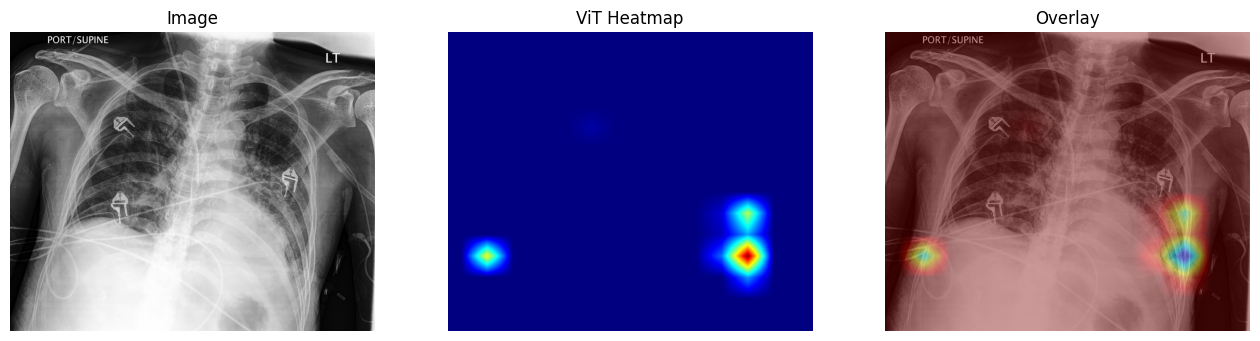

In [19]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import vit_b_16
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------
# Load Image
# ---------------------------
img_path = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/patient64669/study1/view1_frontal.jpg"

img = Image.open(img_path).convert("RGB")

orig_np = np.array(img)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tensor_img = transform(img).unsqueeze(0).cuda()

# ---------------------------
# Load your ViT model
# ---------------------------
model = vit_b_16(weights=None)
model.heads.head = nn.Linear(768, 8)   # 8 classes

ck = torch.load("/content/best_seed_123_model (1).pth", map_location="cpu")
state_dict = ck["model_state_dict"]
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()

# ---------------------------
# Grad-CAM for ViT
# ---------------------------
class ViTGradCAM:
    def __init__(self, model, target_block):
        self.model = model
        self.target_block = target_block

        self.activations = None
        self.gradients = None

        target_block.register_forward_hook(self.forward_hook)
        target_block.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        # output: (batch, seq_len, hidden_dim)
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self):
        # CLS token is index 0
        grad = self.gradients.mean(dim=1, keepdim=True)  # (B,1,D)

        cam = (grad * self.activations).sum(dim=-1)  # (B, seq_len)
        cam = cam[:, 1:]  # remove CLS token

        cam = cam.reshape(1, 14, 14)  # ViT-B/16 → 14×14 patches

        cam = torch.relu(cam)
        cam = cam / cam.max()

        return cam[0].detach().cpu().numpy()

# Use last transformer encoder block
target_block = model.encoder.layers[-1]

cam = ViTGradCAM(model, target_block)

# ---------------------------
# Forward Pass
# ---------------------------
out = model(tensor_img)
class_idx = out.argmax().item()
print("Predicted class:", class_idx)

model.zero_grad()
out[0, class_idx].backward()

heatmap = cam.generate()

# ---------------------------
# Upsample heatmap to image size
# ---------------------------
heatmap = cv2.resize(heatmap, (orig_np.shape[1], orig_np.shape[0]))
heatmap_norm = (heatmap * 255).astype(np.uint8)
heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)

overlay = cv2.addWeighted(orig_np, 0.6, heatmap_color, 0.4, 0)

# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.imshow(orig_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB))
plt.title("ViT Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


SEED 42


In [23]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16

# ----------------------
# Load checkpoint
# ----------------------
ckpt_path = "/content/vit_seed_42_best_model (1).pth"
checkpoint = torch.load(ckpt_path, map_location="cuda")

# ----------------------
# Recreate EXACT architecture
# ----------------------
model = vit_b_16(weights=None)

# Your model is 768 → 8
model.heads.head = nn.Linear(model.heads.head.in_features, 8)

model = model.to("cuda")

# ----------------------
# Load weights
# ----------------------
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Loaded ViT-B/16 with 8 classes successfully!")


Loaded ViT-B/16 with 8 classes successfully!


In [24]:
# final_vit_explainability_fixed.py
import os
import pickle
import json
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torchvision.models import vit_b_16
import pandas as pd

# -----------------------------
# ========== SETTINGS =========
# -----------------------------
CHECKPOINT_PATH = "/content/vit_seed_42_best_model (1).pth"
IMAGE_ROOT = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/"
HEATMAP_ROOT  = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXlocalize/gradcam_maps_val"

NUM_CLASSES     = 8
STEPS           = 30
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_PREFIX      = "vit_explainability"

print("DEVICE:", DEVICE)

# -----------------------------
# ========== MODEL ============
# -----------------------------
# Create ViT-B/16 architecture and set classifier to match NUM_CLASSES
model = vit_b_16(weights=None)           # architecture: ViT-B/16
model.heads.head = nn.Linear(768, NUM_CLASSES)

# Load checkpoint (safe handling)
ck = torch.load(CHECKPOINT_PATH, map_location="cpu")

# If checkpoint stores a nested dict (e.g., "model_state_dict"), use it; otherwise use ck directly
if "model_state_dict" in ck:
    state_dict = ck["model_state_dict"]
else:
    state_dict = ck

# Try to load: if strict fails (unlikely since NUM_CLASSES=8), fallback to safe removal of head keys then strict=False
try:
    model.load_state_dict(state_dict)
    print("Loaded checkpoint with strict=True")
except Exception as e:
    print("Strict load failed:", e)
    # remove common classifier keys if mismatched and load with strict=False
    sd = dict(state_dict)  # copy
    removed = []
    for k in list(sd.keys()):
        # possible classifier key names in various ViT implementations
        if k.endswith("head.weight") or k.endswith("head.bias") or "heads.head" in k or "fc_norm" in k:
            removed.append(k)
            del sd[k]
    print("Removed keys due to mismatch:", removed)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print("Loaded with strict=False. Missing keys:", missing)
    print("Unexpected keys:", unexpected)

model = model.to(DEVICE)
model.eval()

print("Model loaded.")

# -----------------------------
# ========== TRANSFORMS =======
# -----------------------------
norm = transforms.Normalize(mean=[0.485,0.456,0.406],
                            std=[0.229,0.224,0.225])

transform_raw = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

transform_input = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    norm
])

# -----------------------------
# ========== METRICS ==========
# -----------------------------
def average_drop(o, m):
    return max(0, (o - m) / (o + 1e-6))

def increase_in_conf(o, m):
    return max(0, (m - o) / (o + 1e-6))

def heatmap_entropy(h):
    # h is numpy array normalized to [0,1]
    s = h.sum()
    if s <= 0:
        return 0.0
    h_norm = h / s
    return -np.sum(h_norm * np.log(h_norm + 1e-12))

def heatmap_sparsity(h):
    return 1.0 - (np.count_nonzero(h) / h.size)

def deletion_metric(model, img_raw, hm, steps=30):
    """
    Gradually remove (set to 0) most important pixels according to heatmap and record model max score.
    img_raw: tensor [3,H,W] in range [0,1] (un-normalized)
    hm: numpy array HxW with values in [0,1]
    """
    H, W = hm.shape
    flat = hm.flatten()
    order = np.argsort(-flat)  # descending importance indices (numpy)

    raw = img_raw.clone().to(DEVICE)
    mask = torch.ones(H * W, device=DEVICE)

    scores = []
    for s in range(steps):
        k = int((s + 1) / steps * len(order))
        if k > 0:
            # set top-k to 0
            mask[order[:k]] = 0

        m2d = mask.view(H, W)
        m3 = m2d.unsqueeze(0).expand_as(raw)  # [3,H,W]

        masked = raw * m3
        inp = norm(masked).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            out = model(inp)
            # out shape: [1, NUM_CLASSES]
            scores.append(out.max().item())

    return scores

def insertion_metric(model, img_raw, hm, steps=30):
    """
    Gradually insert (reveal) most important pixels according to heatmap starting from blank image.
    Uses blurred=0 (black) baseline similar to your original code.
    """
    H, W = hm.shape
    flat = hm.flatten()
    order = np.argsort(-flat)

    raw = img_raw.clone().to(DEVICE)
    mask = torch.zeros(H * W, device=DEVICE)
    blurred = torch.zeros_like(raw)  # baseline black image

    scores = []
    for s in range(steps):
        k = int((s + 1) / steps * len(order))
        if k > 0:
            mask[order[:k]] = 1

        m2d = mask.view(H, W)
        m3 = m2d.unsqueeze(0).expand_as(raw)

        new = blurred * (1 - m3) + raw * m3
        inp = norm(new).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            out = model(inp)
            scores.append(out.max().item())

    return scores

# -----------------------------
# ========== MAIN LOOP ========
# -----------------------------
results = []
missing_hm = 0
missing_img = 0

patients = sorted([p for p in os.listdir(IMAGE_ROOT)
                   if "patient" in p.lower()])

for patient in tqdm(patients):
    img_path = os.path.join(IMAGE_ROOT, patient, "study1", "view1_frontal.jpg")
    if not os.path.exists(img_path):
        missing_img += 1
        continue

    # ---- AUTOFIND HEATMAP ----
    prefix = f"{patient}_study1_view1_frontal"
    candidates = [f for f in os.listdir(HEATMAP_ROOT) if f.startswith(prefix)]
    if len(candidates) == 0:
        missing_hm += 1
        continue
    heatmap_path = os.path.join(HEATMAP_ROOT, candidates[0])

    # ---- Load image ----
    try:
        pil = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Could not open image {img_path}: {e}")
        missing_img += 1
        continue

    img_raw = transform_raw(pil).float()        # [3,224,224], range [0,1]
    img_input = norm(img_raw).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        orig_out = model(img_input)
        orig_score = orig_out.max().item()

    # ---- Load heatmap ----
    try:
        d = pickle.load(open(heatmap_path, "rb"))
    except Exception as e:
        print(f"Could not load heatmap {heatmap_path}: {e}")
        missing_hm += 1
        continue

    if "map" in d:
        hm = d["map"]
    elif "heatmap" in d:
        hm = d["heatmap"]
    else:
        # try direct object
        hm = d

    if torch.is_tensor(hm):
        hm = hm.cpu().numpy()
    while hasattr(hm, "ndim") and hm.ndim > 2:
        hm = hm.squeeze()

    # Normalize heatmap to [0,1]
    try:
        if hm.max() != hm.min():
            hm = (hm - hm.min()) / (hm.max() - hm.min())
        else:
            hm = np.zeros_like(hm, dtype=np.float32)
    except Exception:
        hm = np.zeros((224, 224), dtype=np.float32)

    # Resize heatmap to 224x224
    try:
        hm = np.array(Image.fromarray((hm * 255).astype("uint8")).resize((224, 224))) / 255.0
    except Exception:
        # if hm is already float in [0,1] shape (224,224) this should be fine
        if hm.shape != (224, 224):
            hm = np.zeros((224, 224), dtype=np.float32)

    hm_t = torch.tensor(hm, dtype=torch.float32)

    # ---- Masked image ----
    mask3 = hm_t.unsqueeze(0).expand_as(img_raw)  # [3,224,224]
    masked_raw = img_raw * mask3
    masked_input = norm(masked_raw).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        masked_out = model(masked_input)
        masked_score = masked_out.max().item()

    # ---- Metrics ----
    ad = average_drop(orig_score, masked_score)
    ic = increase_in_conf(orig_score, masked_score)
    ent = heatmap_entropy(hm)
    spr = heatmap_sparsity(hm)

    del_curve = deletion_metric(model, img_raw, hm, steps=STEPS)
    ins_curve = insertion_metric(model, img_raw, hm, steps=STEPS)

    results.append({
        "patient": patient,
        "avg_drop": ad,
        "inc_conf": ic,
        "entropy": ent,
        "sparsity": spr,
        "deletion": del_curve,
        "insertion": ins_curve
    })

print("Missing images:", missing_img)
print("Missing heatmaps:", missing_hm)
print("Processed:", len(results))

if len(results) == 0:
    raise SystemExit("❌ No results found.")

# -----------------------------
# ========== SAVE RESULTS =====
# -----------------------------
df = pd.DataFrame(results)
df.to_pickle(f"{OUT_PREFIX}_results.pkl")
df.to_csv(f"{OUT_PREFIX}_results.csv", index=False)

print("Saved results:", f"{OUT_PREFIX}_results.csv")


DEVICE: cuda
Loaded checkpoint with strict=True
Model loaded.


100%|██████████| 200/200 [06:41<00:00,  2.01s/it]

Missing images: 0
Missing heatmaps: 0
Processed: 200
Saved results: vit_explainability_results.csv


In [25]:
summary = {
    "avg_drop_mean": float(df["avg_drop"].mean()),
    "avg_drop_std":  float(df["avg_drop"].std()),

    "inc_conf_mean": float(df["inc_conf"].mean()),
    "inc_conf_std":  float(df["inc_conf"].std()),

    "entropy_mean": float(df["entropy"].mean()),
    "entropy_std":  float(df["entropy"].std()),

    "sparsity_mean": float(df["sparsity"].mean()),
    "sparsity_std":  float(df["sparsity"].std()),

    "n_images": len(df)
}

# aggregate deletion/insertion curves
deletion_array  = np.stack(df["deletion"].values)
insertion_array = np.stack(df["insertion"].values)

summary["deletion_curve_mean"] = deletion_array.mean(axis=0).tolist()
summary["deletion_curve_std"]  = deletion_array.std(axis=0).tolist()
summary["insertion_curve_mean"] = insertion_array.mean(axis=0).tolist()
summary["insertion_curve_std"]  = insertion_array.std(axis=0).tolist()

with open(f"{OUT_PREFIX}_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved summary to", f"{OUT_PREFIX}_summary.json")
print("Summary:", {k: summary[k] for k in summary if "curve" not in k})



Saved summary to vit_explainability_summary.json
Summary: {'avg_drop_mean': 0.09408467778447673, 'avg_drop_std': 0.07724602671033386, 'inc_conf_mean': 0.018886858996307286, 'inc_conf_std': 0.04553241685630153, 'entropy_mean': 9.636682463443389, 'entropy_std': 0.4842337319831815, 'sparsity_mean': 0.4110986328125, 'sparsity_std': 0.218719746384018, 'n_images': 200}


Predicted class: 3


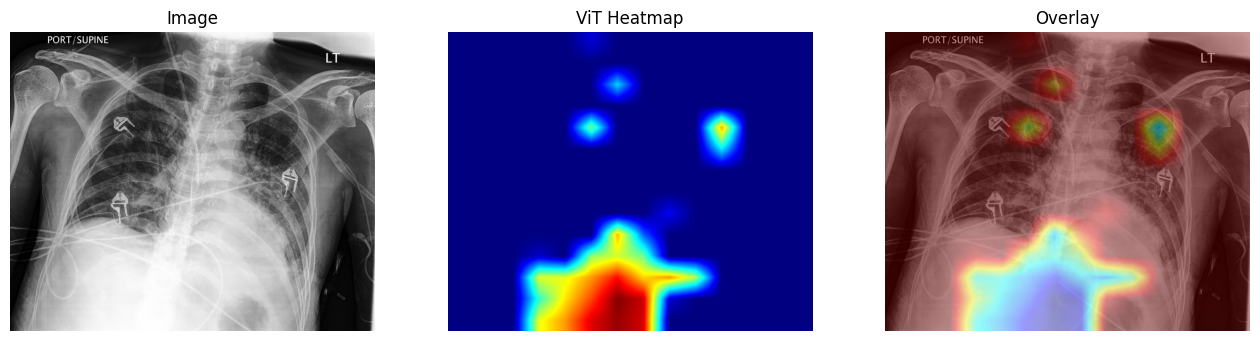

In [26]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import vit_b_16
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------
# Load Image
# ---------------------------
img_path = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/patient64669/study1/view1_frontal.jpg"

img = Image.open(img_path).convert("RGB")

orig_np = np.array(img)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tensor_img = transform(img).unsqueeze(0).cuda()

# ---------------------------
# Load your ViT model
# ---------------------------
model = vit_b_16(weights=None)
model.heads.head = nn.Linear(768, 8)   # 8 classes

ck = torch.load("/content/vit_seed_42_best_model (1).pth", map_location="cpu")
state_dict = ck["model_state_dict"]
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()

# ---------------------------
# Grad-CAM for ViT
# ---------------------------
class ViTGradCAM:
    def __init__(self, model, target_block):
        self.model = model
        self.target_block = target_block

        self.activations = None
        self.gradients = None

        target_block.register_forward_hook(self.forward_hook)
        target_block.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        # output: (batch, seq_len, hidden_dim)
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self):
        # CLS token is index 0
        grad = self.gradients.mean(dim=1, keepdim=True)  # (B,1,D)

        cam = (grad * self.activations).sum(dim=-1)  # (B, seq_len)
        cam = cam[:, 1:]  # remove CLS token

        cam = cam.reshape(1, 14, 14)  # ViT-B/16 → 14×14 patches

        cam = torch.relu(cam)
        cam = cam / cam.max()

        return cam[0].detach().cpu().numpy()

# Use last transformer encoder block
target_block = model.encoder.layers[-1]

cam = ViTGradCAM(model, target_block)

# ---------------------------
# Forward Pass
# ---------------------------
out = model(tensor_img)
class_idx = out.argmax().item()
print("Predicted class:", class_idx)

model.zero_grad()
out[0, class_idx].backward()

heatmap = cam.generate()

# ---------------------------
# Upsample heatmap to image size
# ---------------------------
heatmap = cv2.resize(heatmap, (orig_np.shape[1], orig_np.shape[0]))
heatmap_norm = (heatmap * 255).astype(np.uint8)
heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)

overlay = cv2.addWeighted(orig_np, 0.6, heatmap_color, 0.4, 0)

# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.imshow(orig_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB))
plt.title("ViT Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()
